In [80]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
from pathlib import Path

In [81]:
def apriori_frequent_itemsets(transactions,
                              min_support=0.2,
                              max_size=2,
                              cap_f1=None):
    """
    Apriori za proizvoljan max_size (>=1).
    transactions: dict[id -> set(str)]  // skup n-grama po transakciji
    min_support: relativni prag (0..1)
    max_size: maksimalna veličina itemseta (2 = parovi, 3 = trojke, ...)
    cap_f1: opciono ograničiti broj 1-itema (po supportu) da se ne 'zaleti' kombinatorika
    """
    T = list(transactions.values())
    nT = len(T)
    if nT == 0:
        return {k:{} for k in range(1, max_size+1)}

    # 1-item
    cnt1 = defaultdict(int)
    for items in T:
        for g in items:
            cnt1[g] += 1
    F = {}
    F1 = { (g,): c/nT for g, c in cnt1.items() if (c/nT) >= min_support }
    if cap_f1 is not None and len(F1) > cap_f1:
        F1 = dict(sorted(F1.items(), key=lambda kv: kv[1], reverse=True)[:cap_f1])
    F[1] = F1

    # k >= 2
    k = 2
    prev_freq = set(F1.keys())
    while k <= max_size and prev_freq:
        # kandidati spajanjem
        prev_sorted = sorted(prev_freq)
        Ck = set()
        for i in range(len(prev_sorted)):
            for j in range(i+1, len(prev_sorted)):
                a, b = prev_sorted[i], prev_sorted[j]
                # Apriori join: prvih k-2 elemenata isti
                if a[:k-2] == b[:k-2]:
                    cand = tuple(sorted(set(a) | set(b)))
                    if len(cand) == k and _all_subsets_frequent(cand, prev_freq):
                        Ck.add(cand)

        # broji support
        cntk = defaultdict(int)
        for items in T:
            s = set(items)
            for cand in Ck:
                if set(cand).issubset(s):
                    cntk[cand] += 1
        Fk = { c: cnt/nT for c, cnt in cntk.items() if (cnt/nT) >= min_support }
        if not Fk:
            break
        F[k] = Fk
        prev_freq = set(Fk.keys())
        k += 1

    # osiguraj prazne ključeve do max_size
    for kk in range(1, max_size+1):
        if kk not in F:
            F[kk] = {}
    return F

In [82]:
def _all_subsets_frequent(candidate, prev_freq_set):
    """svi (k-1) podskupovi kandidata moraju biti učestali (Apriori pruning)"""
    k = len(candidate)
    for i in range(k):
        sub = tuple(sorted(candidate[:i] + candidate[i+1:]))
        if sub not in prev_freq_set:
            return False
    return True

In [83]:
def generate_class_rules(transactions,
                         labels,
                         frequent_itemsets,
                         min_confidence=0.8,
                         min_lift=1.1):
    """
    Klasična CAR: itemset => klasa
    transactions: dict[id -> set(items)]
    labels: dict[id -> class_value]
    frequent_itemsets: izlaz iz apriori_frequent_itemsets
    Vraća DataFrame sa: antecedent, size, class, support, confidence, lift, coverage, coverage_count
    """
    tx_ids = list(transactions.keys())
    n = len(tx_ids)
    if n == 0:
        return pd.DataFrame(columns=["antecedent","antecedent_size","class",
                                     "support","confidence","lift","coverage","coverage_count"])

    y = pd.Series([labels[t] for t in tx_ids], index=tx_ids)
    priors = (y.value_counts()/n).to_dict()

    # indeks pokrivenosti po itemsetu 
    rules = []
    for k, Fk in frequent_itemsets.items():
        for itemset, supp in Fk.items():
            covered = [t for t in tx_ids if set(itemset).issubset(transactions[t])]
            cov_cnt = len(covered)
            if cov_cnt == 0:
                continue
            cov_labels = pd.Series([labels[t] for t in covered])
            for cls, cls_cnt in cov_labels.value_counts().items():
                conf = cls_cnt / cov_cnt
                lift = conf / priors[cls]
                sup_cls = cls_cnt / n
                if conf >= min_confidence and lift >= min_lift:
                    rules.append({
                        "antecedent": itemset,
                        "antecedent_size": len(itemset),
                        "class": cls,
                        "support": round(sup_cls, 6),
                        "confidence": round(conf, 6),
                        "lift": round(lift, 6),
                        "coverage": round(cov_cnt / n, 6),
                        "coverage_count": cov_cnt
                    })

    cols = ["antecedent","antecedent_size","class","support","confidence","lift","coverage","coverage_count"]
    if not rules:
        return pd.DataFrame(columns=cols)
    return pd.DataFrame(rules).sort_values(["antecedent_size","confidence","lift","support"],
                                           ascending=[False, False, False, False])

### Visualisations

In [84]:
def plot_rules_network(df_rules: pd.DataFrame, max_edges=50, title="Association Rules Network"):
    # izaberi najjača pravila (po confidence, lift, support)
    df = df_rules.sort_values(["confidence","lift","support"], ascending=False).head(max_edges).copy()

    G = nx.DiGraph()
    for _, row in df.iterrows():
        ants = [str(a) for a in row["antecedent"]] if isinstance(row["antecedent"], (list, tuple)) else [str(row["antecedent"])]
        cls = f"CLASS: {row['class']}"
        ant_node = " ∧ ".join(ants)

        # čvorovi
        G.add_node(ant_node, type="antecedent")
        G.add_node(cls, type="class")

        # ivica sa težinom ~ „snazi“
        weight = float(row["confidence"]) * float(row["lift"])
        G.add_edge(ant_node, cls, weight=weight)

    pos = nx.spring_layout(G, k=0.8, seed=42)

    plt.figure(figsize=(10,7))
    # čvorovi po tipu
    ant_nodes = [n for n, d in G.nodes(data=True) if d.get("type")=="antecedent"]
    cls_nodes = [n for n, d in G.nodes(data=True) if d.get("type")=="class"]

    nx.draw_networkx_nodes(G, pos, nodelist=ant_nodes, node_size=600, alpha=0.8)
    nx.draw_networkx_nodes(G, pos, nodelist=cls_nodes, node_shape="s", node_size=800, alpha=0.9)

    # ivice: debljina proporcionalna težini
    widths = [max(1.0, d["weight"]*2.0) for _,_,d in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=widths, arrows=True, arrowstyle="->", alpha=0.6)

    nx.draw_networkx_labels(G, pos, font_size=8)
    plt.title(title)
    plt.axis("off")
    plt.show()

In [85]:
def plot_rules_per_class(df_rules: pd.DataFrame, title="Broj pravila po klasi"):
    counts = df_rules["class"].value_counts()
    plt.figure(figsize=(6,4))
    plt.bar(counts.index.astype(str), counts.values)
    plt.title(title)
    plt.xlabel("Klasa")
    plt.ylabel("Broj pravila")
    plt.show()

### Aminoacid

In [86]:
def parse_virus_from_col(col: str) -> str:
    cu = str(col).upper()
    if cu.startswith("EBOLA"): return "EBOLA"
    if cu.startswith("MARBURG"): return "MARBURG"
    if cu.startswith("MERS"): return "MERS"
    if cu.startswith("SARS2"): return "SARS2"
    return col

In [87]:
def parse_protein_from_header(value: str, fallback: str) -> str:
    txt = str(value) if pd.notna(value) else ""
    # "membrane glycoprotein - E" → "membrane glycoprotein"
    if " - " in txt and len(txt.split(" - ")[-1]) <= 3:
        base = " - ".join(txt.split(" - ")[:-1]).strip()
        return base if base else fallback
    return txt if txt else fallback

In [88]:
def build_transactions_from_amino_threshold(amino_csv: str, min_count: int = 1):
    df = pd.read_csv(amino_csv)
    header = df.iloc[0]
    df = df.iloc[1:].copy()
    df["ngram"] = df["ngram"].astype(str)
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    grams = df["ngram"].tolist()
    tx = {}
    virus_labels = {}
    protein_labels = {}
    for c in df.columns[1:]:
        virus_labels[c]   = parse_virus_from_col(c)
        protein_labels[c] = parse_protein_from_header(header[c], fallback=c)
        counts = df[c].values
        items = {grams[i] for i, v in enumerate(counts) if v >= min_count}
        tx[c] = items
    return tx, virus_labels, protein_labels

In [89]:
def build_transactions_from_amino_topk(amino_csv: str, K: int = 300):
    df = pd.read_csv(amino_csv)
    header = df.iloc[0]
    df = df.iloc[1:].copy()
    df["ngram"] = df["ngram"].astype(str)
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    grams = df["ngram"].tolist()
    tx = {}
    protein_labels = {}
    for c in df.columns[1:]:
        protein_labels[c] = parse_protein_from_header(header[c], fallback=c)
        counts = df[c].values
        if len(counts) == 0:
            tx[c] = set(); continue
        k = min(K, max(1, len(counts)))
        idx = np.argpartition(-counts, kth=k-1)[:k]
        items = {grams[i] for i in idx if counts[i] > 0}
        tx[c] = items
    return tx, protein_labels

In [90]:
def amino_rules_for_virus(amino_csv: str,
                          use_topk=False, K=300, min_count=1,
                          min_support=0.2, max_size=2, cap_f1=None,
                          min_conf=0.8, min_lift=1.1):
    """
    Pravila: n-gram itemset ⇒ VIRUS (klasa = virus kolone)
    """
    if use_topk:
        tx, prot_labels = build_transactions_from_amino_topk(amino_csv, K=K)
        # iz kolone izvući virus ponovo 
        virus_labels = {col: parse_virus_from_col(col) for col in tx}
    else:
        tx, virus_labels, _ = build_transactions_from_amino_threshold(amino_csv, min_count=min_count)

    F = apriori_frequent_itemsets(tx, min_support=min_support, max_size=max_size, cap_f1=cap_f1)
    rules = generate_class_rules(tx, virus_labels, F, min_confidence=min_conf, min_lift=min_lift)
    return rules

In [91]:
def amino_rules_for_protein(amino_csv: str,
                            use_topk=True, K=300, min_count=1,
                            min_support=0.1, max_size=2, cap_f1=None,
                            min_conf=0.7, min_lift=1.0):
    """
    Pravila: n-gram itemset ⇒ PROTEIN (klasa = naziv proteina iz header reda)
    Po difoltu koristimo Top-K da izbegnemo prazne/pretanke transakcije.
    """
    if use_topk:
        tx, protein_labels = build_transactions_from_amino_topk(amino_csv, K=K)
    else:
        tx, _, protein_labels = build_transactions_from_amino_threshold(amino_csv, min_count=min_count)

    F = apriori_frequent_itemsets(tx, min_support=min_support, max_size=max_size, cap_f1=cap_f1)
    rules = generate_class_rules(tx, protein_labels, F, min_confidence=min_conf, min_lift=min_lift)
    return rules

In [92]:
AMINO_PATH = "../csv_data/3gram_matrix_amino_acid_combined.csv"

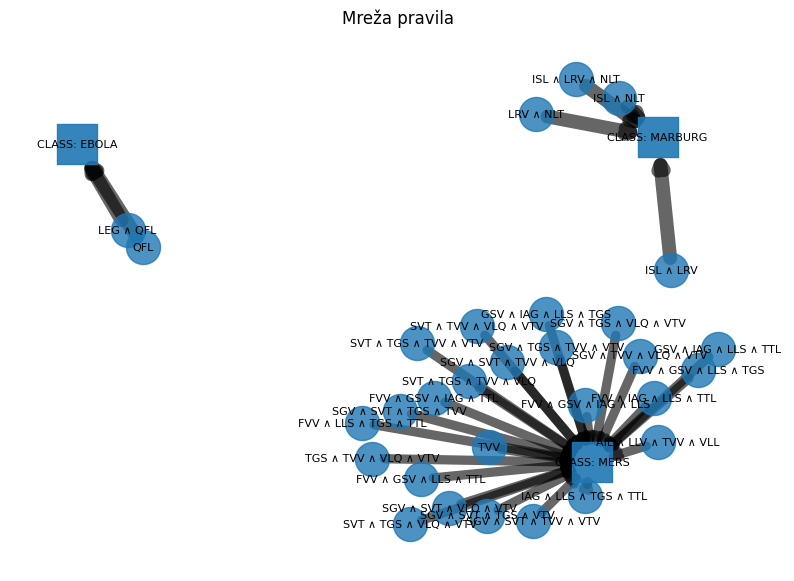

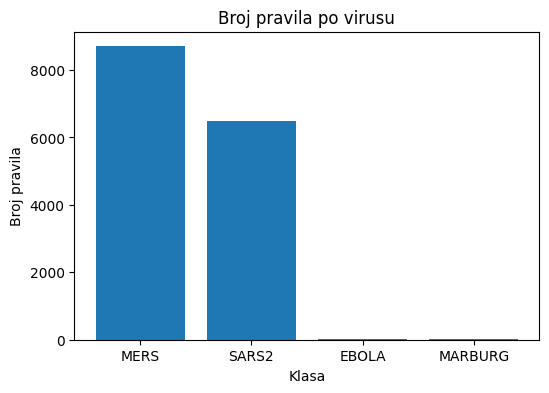

In [93]:
rules_av = amino_rules_for_virus(
    AMINO_PATH,
    use_topk=True,   
    K=150,          
    min_support=0.12,
    max_size=4,     
    cap_f1=150,     
    min_conf=0.65,
    min_lift=1.00
)
rules_av.to_csv("rules_amino_virus_3gram_av.csv", index=False)
plot_rules_network(rules_av, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_av, title="Broj pravila po virusu")

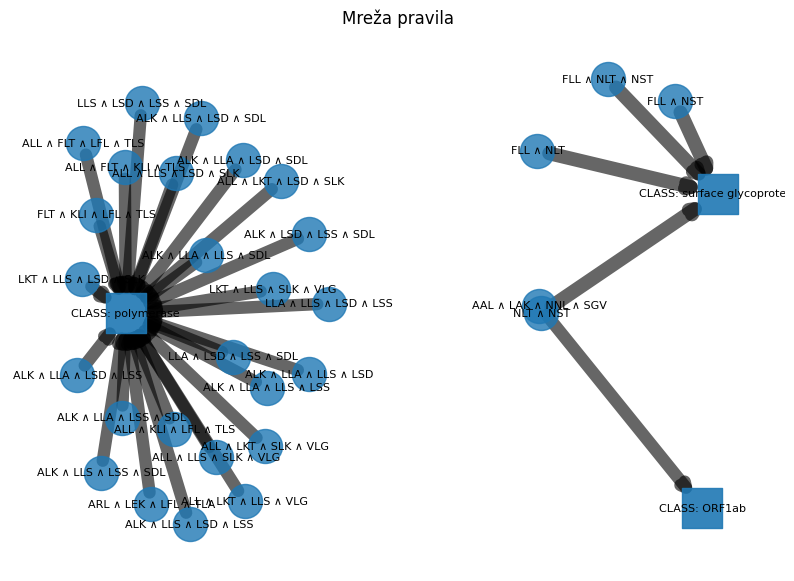

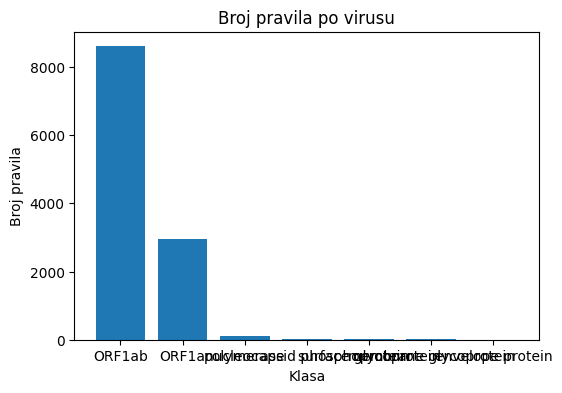

In [94]:
rules_ap = amino_rules_for_protein(
    AMINO_PATH,
    use_topk=True,
    K=150,            
    min_support=0.12,
    max_size=4,     
    cap_f1=150,       
    min_conf=0.65,
    min_lift=1.00
)
rules_ap.to_csv("rules_amino_protein_3gram_ap.csv", index=False)
plot_rules_network(rules_ap, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_ap, title="Broj pravila po virusu")

In [95]:
AMINO_PATH = "../csv_data/4gram_matrix_amino_acid_combined.csv"

/tmp/ipykernel_4428/1572935841.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(amino_csv)


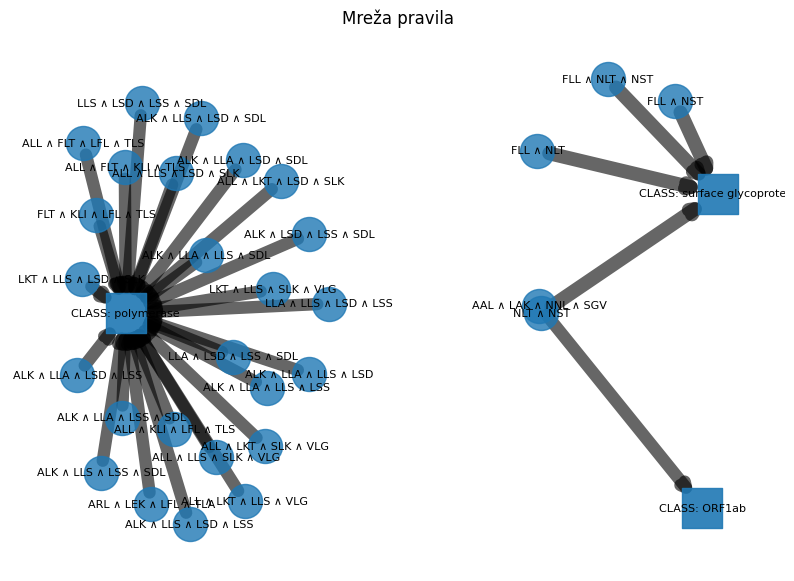

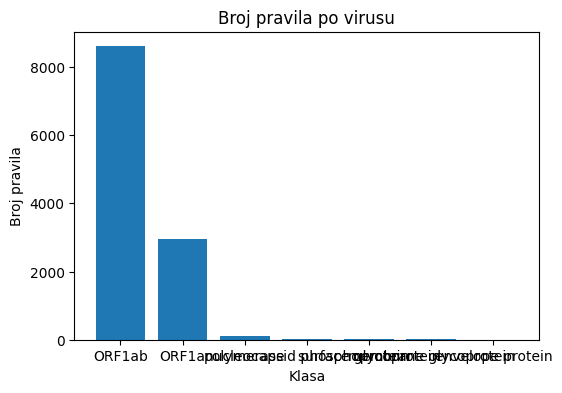

In [96]:
rules_av = amino_rules_for_virus(
    AMINO_PATH,
    use_topk=True,   
    K=150,          
    min_support=0.12,
    max_size=4,     
    cap_f1=150,     
    min_conf=0.65,
    min_lift=1.00
)
rules_av.to_csv("rules_amino_virus_4gram_av.csv", index=False)
plot_rules_network(rules_ap, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_ap, title="Broj pravila po virusu")

/tmp/ipykernel_4428/1572935841.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(amino_csv)


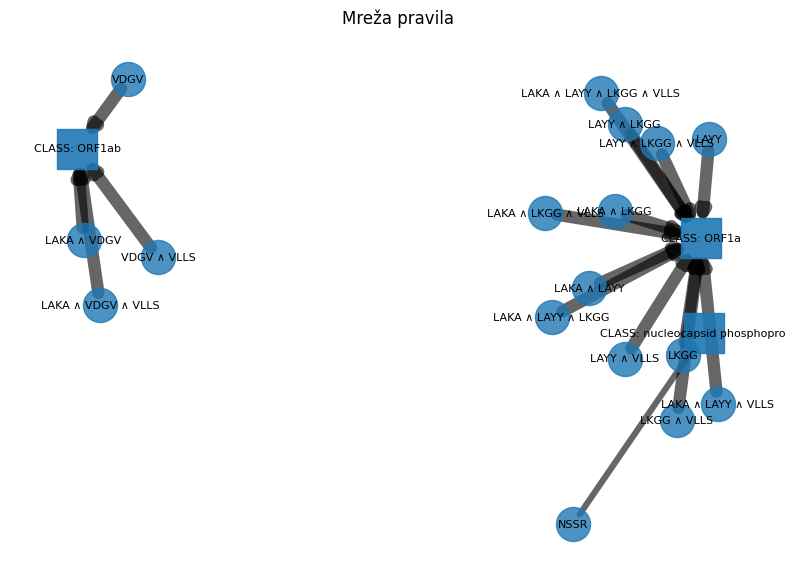

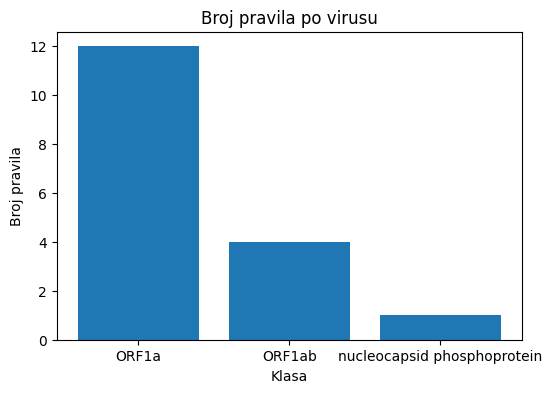

In [97]:
rules_ap = amino_rules_for_protein(
    AMINO_PATH,
    use_topk=True,
    K=150,            
    min_support=0.12,
    max_size=4,     
    cap_f1=150,       
    min_conf=0.65,
    min_lift=1.00
)
rules_ap.to_csv("rules_amino_protein_4gram_ap.csv", index=False)
plot_rules_network(rules_ap, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_ap, title="Broj pravila po virusu")

In [98]:
AMINO_PATH = "../csv_data/5gram_matrix_amino_acid_combined.csv"

/tmp/ipykernel_4428/1572935841.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(amino_csv)


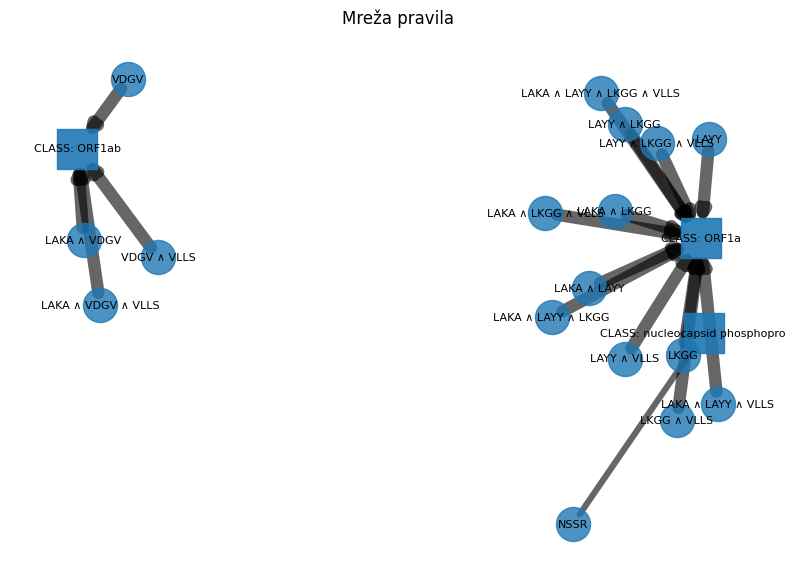

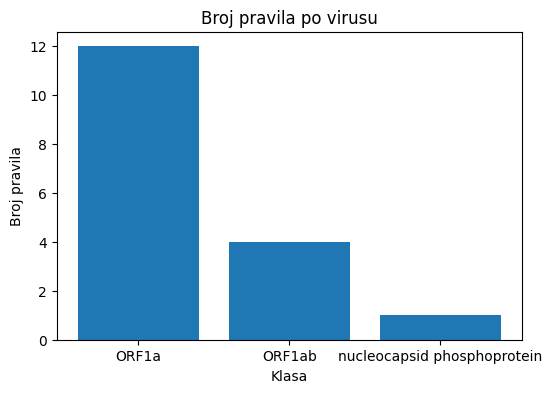

In [99]:
rules_av = amino_rules_for_virus(
    AMINO_PATH,
    use_topk=True,   
    K=150,          
    min_support=0.12,
    max_size=4,     
    cap_f1=150,     
    min_conf=0.65,
    min_lift=1.00
)
rules_av.to_csv("rules_amino_virus_5gram_av.csv", index=False)
plot_rules_network(rules_ap, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_ap, title="Broj pravila po virusu")

/tmp/ipykernel_4428/1572935841.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(amino_csv)


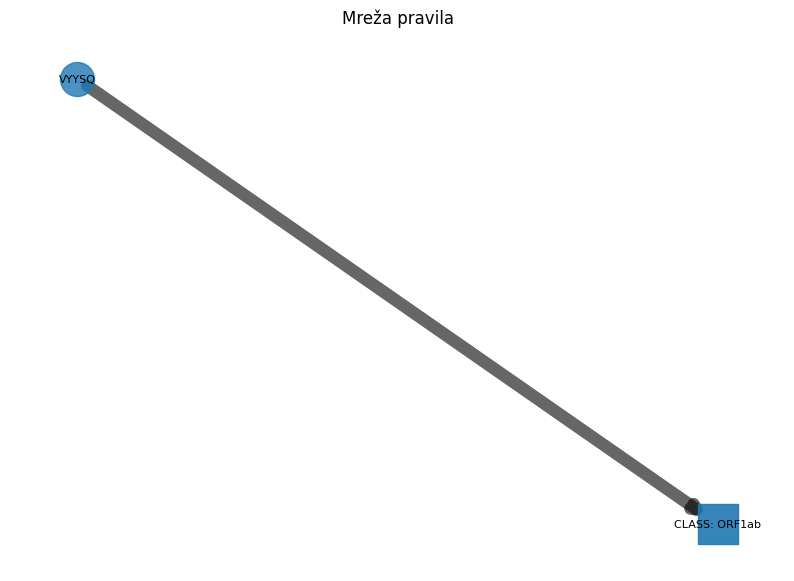

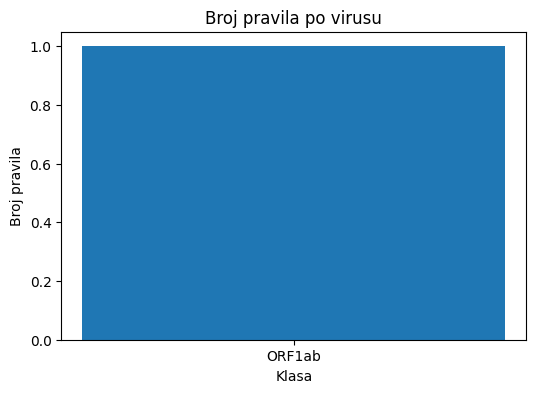

In [100]:
rules_ap = amino_rules_for_protein(
    AMINO_PATH,
    use_topk=True,
    K=150,            
    min_support=0.12,
    max_size=4,     
    cap_f1=150,       
    min_conf=0.65,
    min_lift=1.00
)
rules_ap.to_csv("rules_amino_protein_5gram_ap.csv", index=False)
plot_rules_network(rules_ap, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_ap, title="Broj pravila po virusu")

###  Nucleotide

In [101]:
def build_transactions_from_nucleotide_threshold(nucl_csv: str, min_count: int = 10):
    """
    Svaka kolona (virus) = transakcija = n-grami sa count >= min_count.
    labels: ime kolone (virus).
    """
    df = pd.read_csv(nucl_csv)
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    df["ngram"] = df["ngram"].astype(str)
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    grams = df["ngram"].tolist()
    tx = {}
    labels = {}
    for c in df.columns[1:]:
        labels[c] = c
        counts = df[c].values
        items = {grams[i] for i, v in enumerate(counts) if v >= min_count}
        tx[c] = items
    return tx, labels

In [102]:
def build_transactions_from_nucleotide_topk(nucl_csv: str, K: int = 500):
    """
    Svaka kolona (virus) = transakcija = Top-K n-grama po count-u.
    """
    df = pd.read_csv(nucl_csv)
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    df["ngram"] = df["ngram"].astype(str)
    for c in df.columns[1:]:
        df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0).astype(int)

    grams = df["ngram"].tolist()
    tx = {}
    labels = {}
    for c in df.columns[1:]:
        labels[c] = c
        counts = df[c].values
        if len(counts) == 0:
            tx[c] = set(); continue
        k = min(K, max(1, len(counts)))
        idx = np.argpartition(-counts, kth=k-1)[:k]
        items = {grams[i] for i in idx if counts[i] > 0}
        tx[c] = items
    return tx, labels

In [103]:
def nucleotide_rules_for_virus(nucl_csv: str,
                               use_topk=False, K=500, min_count=10,
                               min_support=0.25, max_size=2, cap_f1=None,
                               min_conf=0.7, min_lift=1.0):
    """
    Pravila: n-gram itemset ⇒ VIRUS (kolona ime).
    """
    if use_topk:
        tx, labels = build_transactions_from_nucleotide_topk(nucl_csv, K=K)
    else:
        tx, labels = build_transactions_from_nucleotide_threshold(nucl_csv, min_count=min_count)

    F = apriori_frequent_itemsets(tx, min_support=min_support, max_size=max_size, cap_f1=cap_f1)
    rules = generate_class_rules(tx, labels, F, min_confidence=min_conf, min_lift=min_lift)
    return rules

In [104]:
NUCL_PATH = "../csv_data/6gram_matrix_nucleotide_combined.csv"

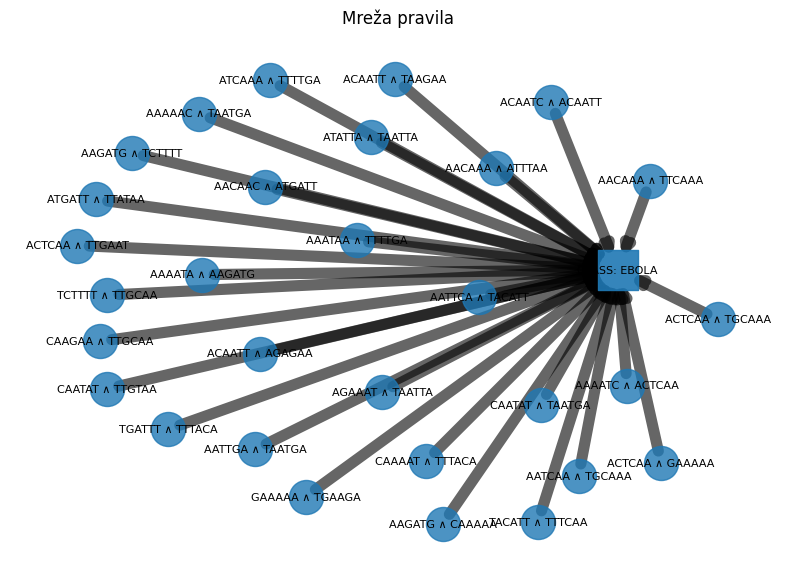

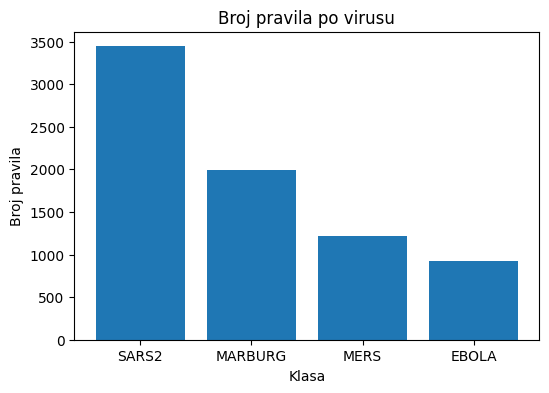

In [105]:
rules_nv = nucleotide_rules_for_virus(
    NUCL_PATH,
    use_topk=True,    
    K=200,           
    min_support=0.12,
    max_size=2,       
    cap_f1=200,       
    min_conf=0.70,
    min_lift=1.00
)
rules_nv.to_csv("rules_nucleotide_virus_6gram.csv", index=False)
plot_rules_network(rules_nv, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_nv, title="Broj pravila po virusu")

In [106]:
NUCL_PATH = "../csv_data/7gram_matrix_nucleotide_combined.csv"

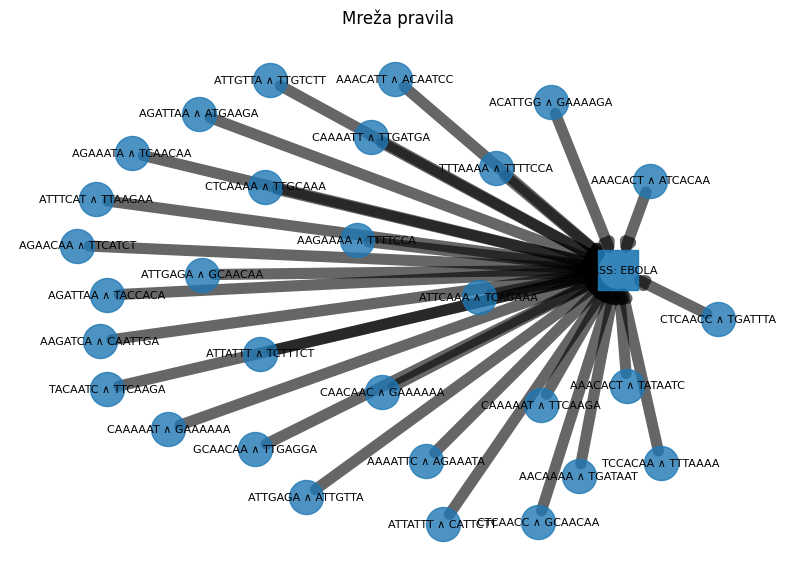

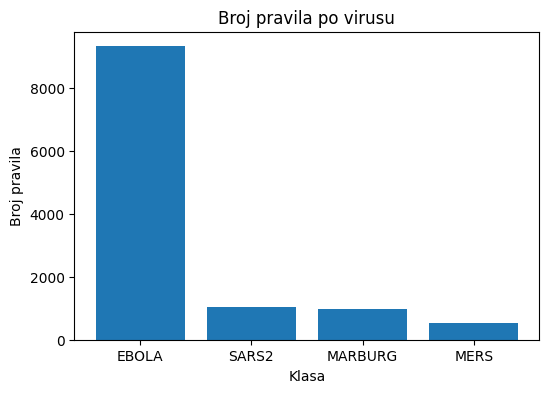

In [107]:
rules_nv = nucleotide_rules_for_virus(
    NUCL_PATH,
    use_topk=True,    
    K=200,           
    min_support=0.12,
    max_size=2,       
    cap_f1=200,       
    min_conf=0.70,
    min_lift=1.00
)
rules_nv.to_csv("rules_nucleotide_virus_7gram.csv", index=False)
plot_rules_network(rules_nv, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_nv, title="Broj pravila po virusu")

In [108]:
NUCL_PATH = "../csv_data/8gram_matrix_nucleotide_combined.csv"

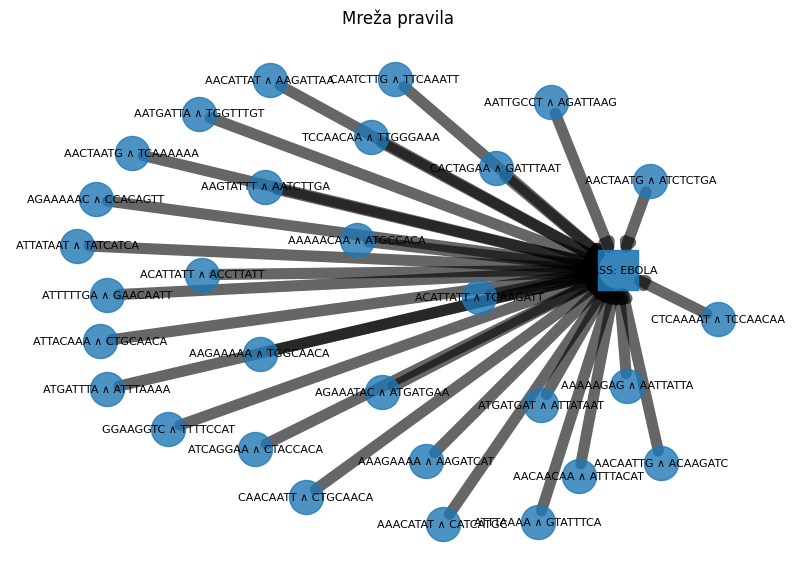

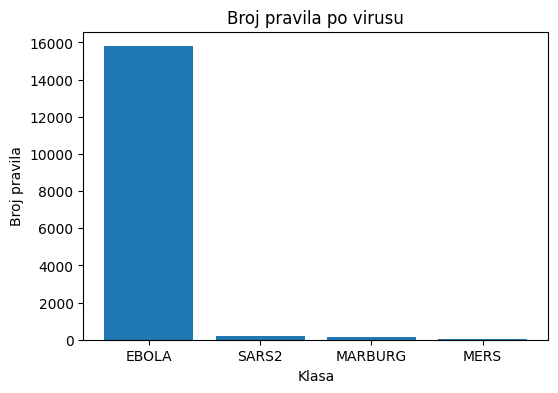

In [109]:
rules_nv = nucleotide_rules_for_virus(
    NUCL_PATH,
    use_topk=True,    
    K=200,           
    min_support=0.12,
    max_size=2,       
    cap_f1=200,       
    min_conf=0.70,
    min_lift=1.00
)
rules_nv.to_csv("rules_nucleotide_virus_8gram.csv", index=False)
plot_rules_network(rules_nv, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_nv, title="Broj pravila po virusu")

In [110]:
NUCL_PATH = "../csv_data/9gram_matrix_nucleotide_combined.csv"

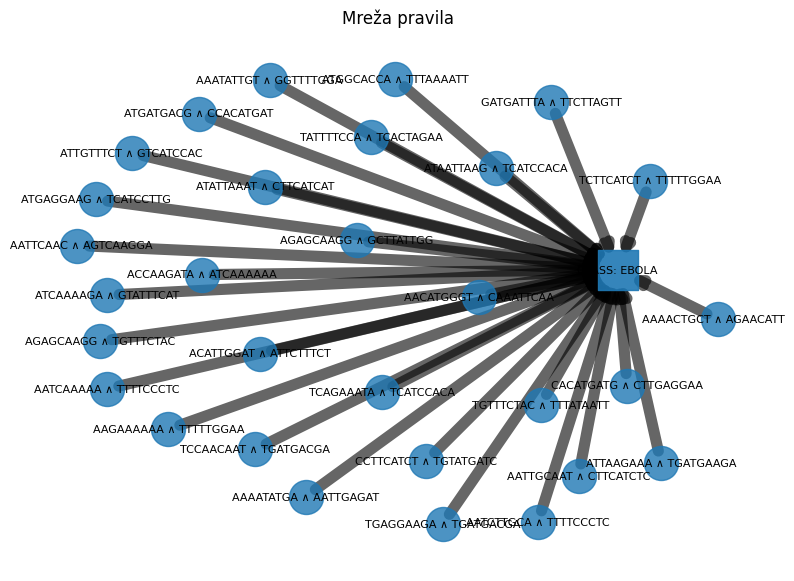

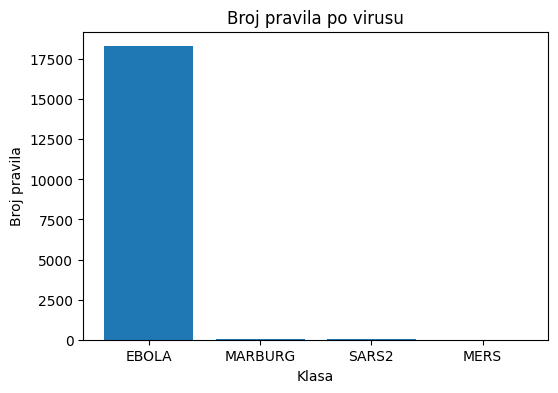

In [111]:
rules_nv = nucleotide_rules_for_virus(
    NUCL_PATH,
    use_topk=True,    
    K=200,           
    min_support=0.12,
    max_size=2,       
    cap_f1=200,       
    min_conf=0.70,
    min_lift=1.00
)
rules_nv.to_csv("rules_nucleotide_virus_9gram.csv", index=False)
plot_rules_network(rules_nv, max_edges=30, title="Mreža pravila")
plot_rules_per_class(rules_nv, title="Broj pravila po virusu")